In [1]:
import numpy as np
import csv
import pickle
from math import floor, log10
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# need some of my own functions
import os, sys
base = '/Users/robertseaton/School/github_repos/CGM-learning/code'
if base not in sys.path:
    sys.path.insert(0, os.path.abspath(base))
from bobutils import data_analysis as da

In [2]:
import numpy as np

def create_circular_mask(r):
    n = 2*r + 1  # size of the output array
    center = r  # center of the circular mask

    # create a n x n array filled with the Euclidean distance from the center
    y, x = np.ogrid[-center:n-center, -center:n-center]
    mask = np.sqrt(x**2 + y**2)

    # normalize the mask to have values between 0 and 1
    mask = 1 - mask / (r+0.75)
    mask[mask < 0] = 0

    return mask

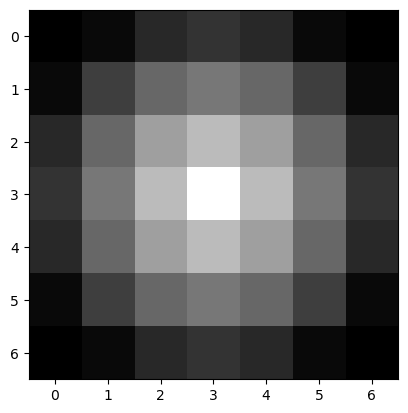

In [4]:
import matplotlib.pyplot as plt

# Create a mask with radius 10
mask = create_circular_mask(3)

# Display the mask
plt.imshow(mask, cmap='gray')
plt.show()

In [2]:
def sig_figs(x: float, precision: int = 6):
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """

    x = float(x)
    precision = int(precision)

    return round(x, -int(floor(log10(abs(x)))) + (precision - 1))

In [3]:
def find_pickle_files(directory):
    """Recursively search for pickle files in a directory."""
    pickle_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".p"):
                pickle_files.append(os.path.join(root, file))

    return pickle_files

In [4]:
def get_ions_from_pickle(pickle_file):
    """Return the ions from a pickle file."""
    with open(pickle_file, 'rb') as f:
        ions = pickle.load(f)
    return ions

In [5]:
def get_metadata_from_pickle(analysis_dir, pickle_filename):
    """Return the metadata contained in the pickle filename."""
    file_parts = pickle_filename.split(analysis_dir)[1].split('/')[1:3]
    vals = file_parts[0].replace('.', 'x').replace('-', '_').split('_')
    sightline_num = vals[0]
    coords = vals[3]
    ap_size = vals[4]
    redshift = float(file_parts[1].split('z_')[1])
    

    return sightline_num,redshift,coords,ap_size

In [6]:
DEBUG = False


In [7]:
def show_ion_data(ions, show_key):
    """Print the data for a given key."""
    if DEBUG: print(f"Absorber: {show_key} --- ")

    # the abs_keys are all of the measurements for that ion
    abs_keys = ions[show_key].keys()
    for abs_key in sorted(abs_keys):
        if DEBUG: print(f"   {abs_key} ::: {np.shape(ions[show_key][abs_key])}")    


In [23]:
def prepare_data(ion, use_vel=False):
    """prepare the ion ready for the gaussian fitting."""
    """Prepare the data: Choose how you want to do the analysis, and set the analysis range/limits"""
    vel = ion['vel']
    x_lim = ion['window_lim']
    wave  = ion['wave']
    ew_lims = ion['EWlims']
    flux = ion['flux']
    y_error = ion['error']
    cont = ion['cont']
    name = ion['name']
    zabs = ion['z']    
    
    x1_index = np.where(vel >= ew_lims[0])[0][0] # the x index where the velocity is greater than the lower limit
    x2_index = np.where(vel >= ew_lims[1])[0][0] # the x index where the velocity is greater than the upper limit
    if DEBUG: print(f"x1_index = {x1_index}   x2_index = {x2_index}")
    if use_vel:
        if DEBUG: print('Using velocity')
        adj = 0
        xdata = vel
        ewlims = [ew_lims[0]-adj, ew_lims[1]+adj]
        wlims = [-2000,2000]
    else: 
        if DEBUG: print('Using wavelength')
        xdata = wave
        ewlims = [wave[x1_index-1],wave[x2_index+1]]
        right_bound = x2_index+min(20, len(wave)-x2_index-1)
        if DEBUG: print(f"Right Bound: {right_bound}")
        wlims = [wave[x1_index-20],wave[right_bound]]

    # normalize the flux and error to the continuum
    nflux = flux/cont
    nerror = y_error/cont

    # print(f"ewlims = {ewlims}")
    ewlims_rest = [ewlims[0]/(1. + zabs),ewlims[1]/(1. + zabs)]
    # print(f"ewlims-obs: {ewlims}")
    # print(f"ewlims_rest: {ewlims_rest}")

    delwv       = np.double(ewlims[1])-np.double(ewlims[0])
    delwv_rest  = np.double(ewlims_rest[1])-np.double(ewlims_rest[0])
    # print(f"delwv = {delwv}   delvw_rest = {delwv_rest}")  

    # to limit the influence of points away from the signal of interest, we limit the analysis range
    wingspan = delwv / 2.0

    new_limits = (xdata >= ewlims[0]-wingspan) & (xdata <= ewlims[1]+wingspan)
    gxdata = xdata[new_limits]
    gxdata_rest = gxdata/(1. + zabs)
    # print(f"gxdata-obs: {gxdata}")
    # print(f"gxdata-rest: {gxdata_rest}")

    gnflux = nflux[new_limits]
    gnerror = nerror[new_limits]
    if DEBUG: print(f"limiting fit analysis range to {ewlims[0]-delwv}, {ewlims[1]+delwv}")  

    return xdata, nflux, nerror, gxdata_rest, gnflux, gnerror, ewlims_rest, wlims, wingspan

In [24]:
def fit_and_compute_ew(wave, flux, ewlims_rest):
    """Compute the equivalent width of an ion."""
    """wave is either the rest-frame wavelength or the velocity."""
    """flux is the normalized flux, ewlims_rest is the rest-frame equivalent width limits in Angstroms."""
    g, fit_g, good_fit = da.create_gaussian_fitter(wave, flux, ewlims_rest)
    if good_fit:
        ew, ew_sig = da.calculate_ew_from_gaussian(g, fit_g, ewlims_rest)
        ew = 1000 * ew # convert to mAngstroms
    else:
        ew = 0
        ew_sig = 0
    return g, fit_g, ew, ew_sig, good_fit

In [25]:
# def plot_fit(xdata, nflux, use_vel, zabs, wlims, ewlims_rest, wingspan, sightline, ion_name, g, ew, ew_sig, nerror, good_fit):
def plot_fit(xdata, nflux, use_vel,  wlims, ewlims_rest, wingspan, sightline_num, zabs, ion, g, ew, ew_sig, nerror, good_fit):

    fig = plt.figure(figsize=(10, 4))
    wlims_rest = [wlims[0]/(1. + zabs),wlims[1]/(1. + zabs)]
    fit_xdata = np.linspace(wlims_rest[0], wlims_rest[1], 1000) # just gives the fit a smooth look
    gs = GridSpec(2, 1, height_ratios=[6, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax1.axvspan(ewlims_rest[0]-wingspan, ewlims_rest[1]+wingspan, alpha=0.2, color='tab:gray')
    ax1.plot(xdata, nflux, 'o', color="tab:blue", label="flux", linewidth=1.0, markersize=5)
    ax1.plot(fit_xdata, g(fit_xdata), 
            '-', 
            color="tab:green", 
            linewidth=5.0, alpha=0.5,
            markersize=5)
    continuum = g.parameters[0]

    ax1.fill_between(fit_xdata, continuum, g(fit_xdata), alpha=0.7)

    flux_max = np.max(np.abs(nflux))
    flux_min = np.min(np.abs(nflux))

    ax1.vlines(ewlims_rest, flux_min, flux_max, color="tab:red") 

    ax1.set_xlim(wlims_rest)
    ax1.set_ylabel('Normalized Flux')
    ax1.grid(True)
    ax1.set_title(ion)

    ax1.spines[["left", "top", "right"]].set_visible(False)
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax1.margins(y=0.1)

    ax1.text(.7, 1.0, 
            f"""
            Sightline: {sightline_num}
            Ion: {ion}
            z_abs: {zabs:.4f}
            EW: {ew:.2f} $\pm$ {ew_sig:.2f} $m\AA$
            EW Limits: {ewlims_rest[0]:.2f}, {ewlims_rest[1]:.2f}
            """, 
            transform=ax1.transAxes,
            fontsize=10, color='black', 
            backgroundcolor='#aaaaff77',
            ha='left', va='top')


    if use_vel:
        ax2.set_xlabel('velocity (km/s)')
    else:
        ax2.set_xlabel('wavelength ($m\AA$)')
    ax2.plot(xdata, nerror, color="tab:red", label="flux", ms=4, linewidth=1.0, alpha=1)
    ax2.spines[["left", "top", "right"]].set_visible(False)
    ax2.set_ylabel('error')
    ax2.grid(True)
    ax2.margins(y=0.1)

    print()


In [32]:
def plot_ion(ion, ii, ax, g, ew, ew_sig, good_fit, xdata, nflux, use_vel, wlims, ewlims_rest, wingspan, nerror, zabs):    
    """ Plot the ion and fit data. """
    
    ax.set_title(f"{ion}", loc='center', fontstyle='oblique', fontsize='medium')

    # ax.text(0.5, 0.5, f"ax{(ii+1):2d}: {ion}" , va="center", ha="center")

    wlims_rest = [wlims[0]/(1. + zabs),wlims[1]/(1. + zabs)]
    fit_xdata = np.linspace(wlims_rest[0], wlims_rest[1], 1000) # just gives the fit a smooth look

    ax.axvspan(ewlims_rest[0]-wingspan, ewlims_rest[1]+wingspan, alpha=0.2, color='tab:gray')
    
    ax.plot(xdata/(1. + zabs), nflux, 'o', color="tab:blue", label="flux", linewidth=1.0, markersize=5)
    ax.plot(fit_xdata, g(fit_xdata), 
            '-', 
            color="tab:green", 
            linewidth=5.0, alpha=0.5,
            markersize=5)
    continuum = g.parameters[0]

    ax.fill_between(fit_xdata, continuum, g(fit_xdata), alpha=0.7)

    flux_max = np.max(np.abs(nflux))
    flux_min = np.min(np.abs(nflux))

    ax.vlines(ewlims_rest, flux_min, flux_max, color="tab:red") 

    ax.set_xlim(wlims_rest)
    ax.set_ylabel('Normalized Flux')
    ax.grid(True)
    ax.set_title(ion)

    ax.spines[["left", "top", "right"]].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
    ax.margins(y=0.1)

    # if good_fit:
    #     ax.text(.7, 1.0, 
    #             f"""
    #             EW: {ew:.2f} $\pm$ {ew_sig:.2f} $m\AA$
    #             EW Limits: {ewlims_rest[0]:.2f}, {ewlims_rest[1]:.2f}
    #             """, 
    #             transform=ax.transAxes,
    #             fontsize=10, color='black', 
    #             backgroundcolor='#aaaaff77',
    #             ha='left', va='top'
    #             )
        
    # else:
    #     ax.text(.7, 1.0, 
    #             f"""
    #             Bad Fit. Check initial conditions.
    #             """, 
    #             transform=ax.transAxes,
    #             fontsize=10, color='red', 
    #             backgroundcolor='#ffaaaa77',
    #             ha='left', va='top'
    #             )


In [33]:
def plot_ions(ions, sightline_num, zabs, coords, ap_size):

    """Plot the ions."""
    # create the page to plot the EWs: 2 columns, int(ion_count/2)+1 rows
    ion_count = len(ions)
    row_count = np.ceil(len(ions)/2).astype(int)
    
    fig = plt.figure(tight_layout=True, figsize=(8, 2*row_count))
    figure_title = f"sightline: {sightline_num}   z: {zabs}   coords: {coords}   aperature: {ap_size} "
    fig.suptitle(figure_title)

    gs = gridspec.GridSpec(row_count, 2)

    use_vel = True
    for ii, ion in enumerate(ions.keys()):
        r = ii // 2
        c = ii % 2
        ax = fig.add_subplot(gs[r, c])

        xdata, nflux, nerror, gxdata, gnflux, gnerror, ewlims_rest, wlims, wingspan = prepare_data(ions[ion], use_vel)
        g, fit_g, ew, ew_sig, good_fit = fit_and_compute_ew(gxdata, gnflux, ewlims_rest)
        plot_ion(ion, ii, ax, g, ew, ew_sig, good_fit, xdata, nflux, use_vel, wlims, ewlims_rest, wingspan, nerror, zabs)


fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses
fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses


fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses
fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses
fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses


fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses
fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses
fit_info['param_cov'] is None - The fit is not sensible! Check initial_guesses


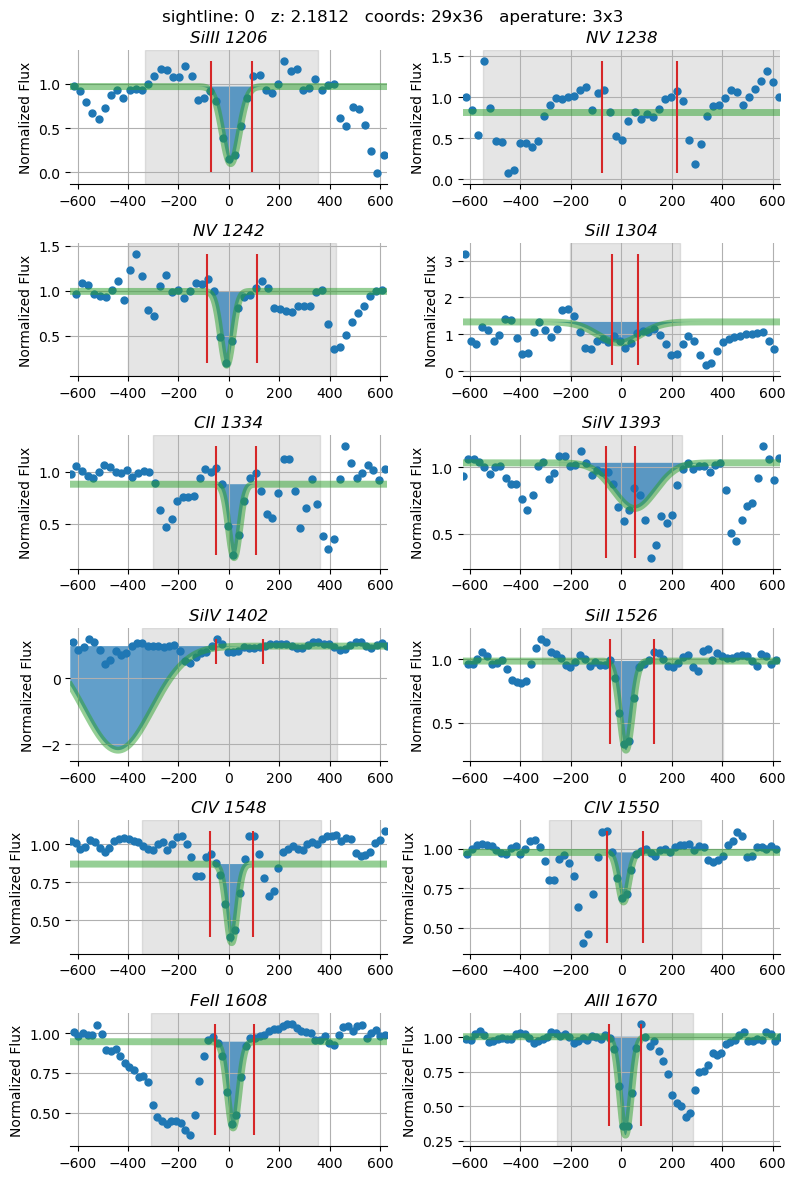

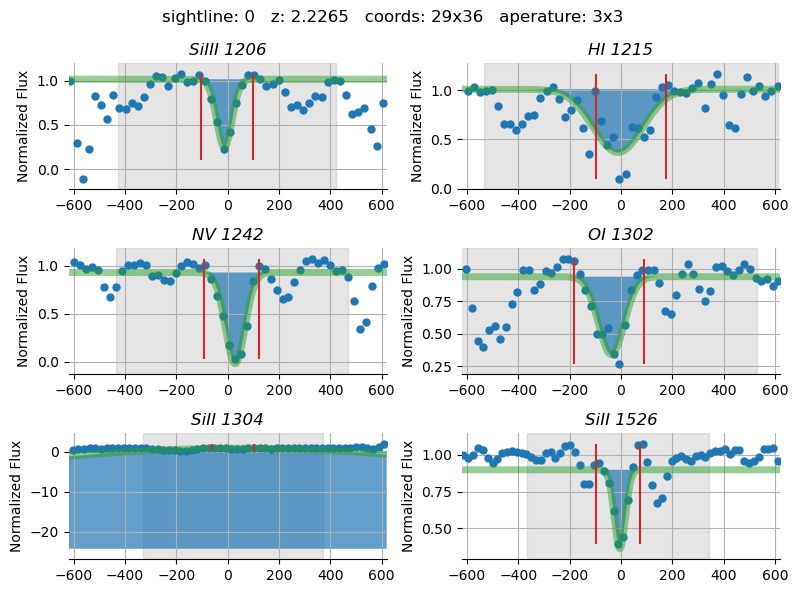

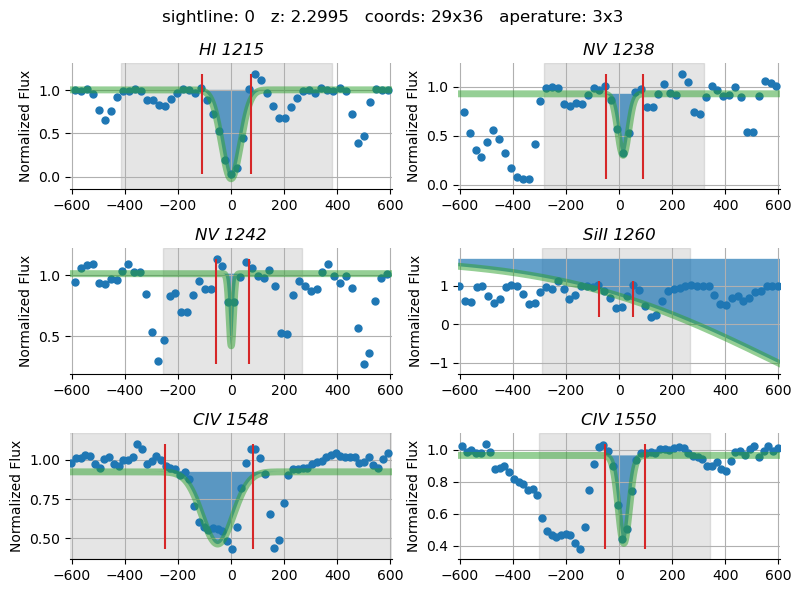

In [34]:
# For each z (we've got either 4 or 5 -- boy, you need to decide this)
#    * For each sightline
#      * Display a page of ions (absorbers / emitters) along with their calculated equivalent widths
#        * remember to put the error bars around the EW when you plot
def main():
    # find all of the pickle files below the specified directory
    analysis_dir = '/Users/robertseaton/School/github_repos/CGM-learning/code/analysis/j1429'
    pickle_files_list = find_pickle_files(analysis_dir)

    use_vel = True
    # each pickle file represents a collections of ions found along a sightline at a given redshift
    for pickle_file in sorted(pickle_files_list)[0:3]: 
        sightline_num,zabs,coords,ap_size=get_metadata_from_pickle(analysis_dir, pickle_file)

        ions = get_ions_from_pickle(pickle_file)
        # show_ion_data(ions, list(ions.keys())[0])
        if "Target" in ions:
            del ions["Target"]
        plot_ions(ions, sightline_num=sightline_num, zabs=zabs, coords=coords, ap_size=ap_size)
        # stick all of the data for the ion into a dataframe



if __name__ == '__main__':
    main()